In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras import layers, models
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications import ResNet101
from keras.applications import DenseNet201, DenseNet169, DenseNet121
from keras.applications import InceptionV3
from keras.applications import InceptionResNetV2
from keras.applications import Xception
from keras.applications import MobileNetV2
from keras.applications import MobileNet
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score

init_notebook_mode(connected=True)
RANDOM_SEED = 123

Using TensorFlow backend.


# Data Import and Preprocessing

In [8]:
IMG_PATH = 'brain_tumor_dataset/'
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/' + CLASS.upper() + '/' + FILE_NAME) 

In [3]:
def load_data(dir_path, img_size=(100, 100)):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print('{} images loaded from {} directory.'.format(len(X), dir_path))
    return X, y, labels
    

In [4]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224, 224)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  4.11it/s]
C:\Users\zeyne\anaconda3\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

  0%|          | 0/2 [00:00<?, ?it/s]

242 images loaded from TRAIN/ directory.
19 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 10.90it/s]

92 images loaded from VAL/ directory.


In [5]:
def preprocess_imgs(set_name, img_size):
    
    # Resize and apply VGG-15 preprocessing
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [6]:
X_train_prep = preprocess_imgs(set_name=X_train, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val, img_size=IMG_SIZE)

# CNN Pre-trained Models

## Data Augmentation

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)


Found 242 images belonging to 2 classes.
Found 92 images belonging to 2 classes.


## VGG-16

In [12]:
# loading base model
base_model_vgg = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

58892288/58889256 [==============================] - 5s 0us/step


In [13]:
NUM_CLASSES = 1

model_vgg = Sequential()
model_vgg.add(base_model_vgg)
model_vgg.add(layers.Flatten())
model_vgg.add(layers.Dropout(0.5))
model_vgg.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_vgg.layers[0].trainable = False

model_vgg.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
EPOCHS = 30

history_vgg = model_vgg.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
    )

Epoch 1/30
8/8 [==============================] - 18s 2s/step - loss: 5.3303 - accuracy: 0.5165 - val_loss: 0.4099 - val_accuracy: 0.7174
Epoch 2/30
8/8 [==============================] - 2s 279ms/step - loss: 3.4246 - accuracy: 0.6157 - val_loss: 1.8743 - val_accuracy: 0.8261
Epoch 3/30
8/8 [==============================] - 3s 351ms/step - loss: 3.7456 - accuracy: 0.6240 - val_loss: 2.6186 - val_accuracy: 0.8587
Epoch 4/30
8/8 [==============================] - 3s 345ms/step - loss: 2.9905 - accuracy: 0.6818 - val_loss: 0.8381 - val_accuracy: 0.8696
Epoch 5/30
8/8 [==============================] - 3s 351ms/step - loss: 3.1882 - accuracy: 0.6901 - val_loss: 0.1546 - val_accuracy: 0.9130
Epoch 6/30
8/8 [==============================] - 3s 356ms/step - loss: 2.3901 - accuracy: 0.7190 - val_loss: 0.5545 - val_accuracy: 0.9022
Epoch 7/30
8/8 [==============================] - 3s 357ms/step - loss: 2.4489 - accuracy: 0.6983 - val_loss: 0.0073 - val_accuracy: 0.9239
Epoch 8/30
8/8 [======

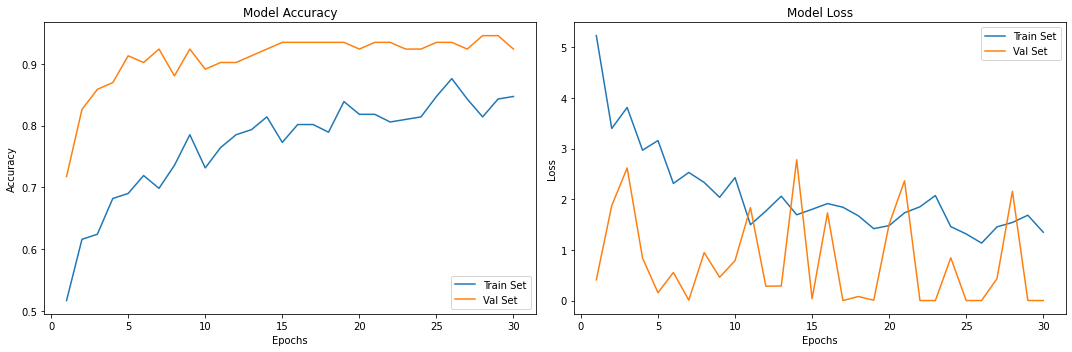

In [15]:
# plot model performance
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
epochs_range = range(1, len(history_vgg.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [68]:
# validate on test set
predictions = model_vgg.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.85
Test Accuracy = 0.95
Val Accuracy = 0.92
Kappa Score = 0.89
ROC Area = 0.94
Precision = 0.95


### VGG19

In [92]:
# loading base model
base_model_vgg = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

80142336/80134624 [==============================] - 8s 0us/step


In [93]:
NUM_CLASSES = 1

model_vgg19 = Sequential()
model_vgg19.add(base_model_dense)
model_vgg19.add(layers.Flatten())
model_vgg19.add(layers.Dropout(0.5))
model_vgg19.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_vgg19.layers[0].trainable = False

model_vgg19.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_vgg19.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten_6 (Flatten)          (None, 94080)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 94080)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 94081     
Total params: 18,416,065
Trainable params: 94,081
Non-trainable params: 18,321,984
_________________________________________________________________


In [94]:
history_vgg19 = model_vgg19.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
8/8 [==============================] - 24s 3s/step - loss: 0.9489 - accuracy: 0.5868 - val_loss: 7.8369 - val_accuracy: 0.6196
Epoch 2/30
8/8 [==============================] - 5s 579ms/step - loss: 0.6298 - accuracy: 0.7190 - val_loss: 3.0158 - val_accuracy: 0.4674
Epoch 3/30
8/8 [==============================] - 5s 600ms/step - loss: 0.6131 - accuracy: 0.7273 - val_loss: 10.4179 - val_accuracy: 0.6196
Epoch 4/30
8/8 [==============================] - 5s 584ms/step - loss: 0.4971 - accuracy: 0.7727 - val_loss: 11.6149 - val_accuracy: 0.6196
Epoch 5/30
8/8 [==============================] - 5s 580ms/step - loss: 0.4733 - accuracy: 0.7851 - val_loss: 9.1916 - val_accuracy: 0.6196
Epoch 6/30
8/8 [==============================] - 5s 579ms/step - loss: 0.4228 - accuracy: 0.8017 - val_loss: 9.9496 - val_accuracy: 0.6196
Epoch 7/30
8/8 [==============================] - 5s 579ms/step - loss: 0.4211 - accuracy: 0.8306 - val_loss: 12.8375 - val_accuracy: 0.6196
Epoch 8/30
8/8 [===

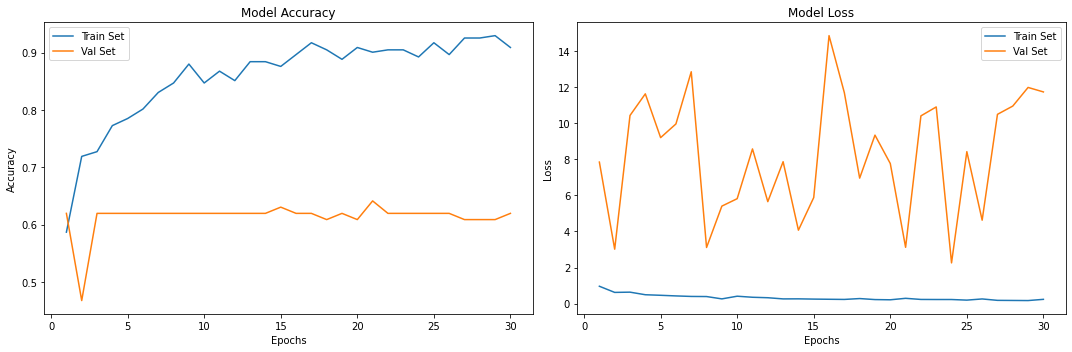

In [95]:
# plot model performance
acc = history_vgg19.history['accuracy']
val_acc = history_vgg19.history['val_accuracy']
loss = history_vgg19.history['loss']
val_loss = history_vgg19.history['val_loss']
epochs_range = range(1, len(history_dense.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [97]:
# validate on test set
predictions = model_vgg19.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.91
Test Accuracy = 0.47
Val Accuracy = 0.62
Kappa Score = 0.00
ROC Area = 0.50
F1 Score = 0.32


C:\Users\zeyne\anaconda3\envs\keras-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### DenseNet 121

In [104]:
# load base model
base_model_dense = DenseNet121(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

29089792/29084464 [==============================] - 3s 0us/step


In [107]:
NUM_CLASSES = 1

model_dense121 = Sequential()
model_dense121.add(base_model_dense)
model_dense121.add(layers.Flatten())
model_dense121.add(layers.Dropout(0.5))
model_dense121.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_dense121.layers[0].trainable = False

model_dense121.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_dense121.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_8 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 50176)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 50177     
Total params: 7,087,681
Trainable params: 50,177
Non-trainable params: 7,037,504
_________________________________________________________________


In [108]:
history_dense121 = model_dense121.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
8/8 [==============================] - 16s 2s/step - loss: 1.0524 - accuracy: 0.5744 - val_loss: 1.7042 - val_accuracy: 0.6087
Epoch 2/30
8/8 [==============================] - 3s 365ms/step - loss: 0.8411 - accuracy: 0.6116 - val_loss: 1.5268 - val_accuracy: 0.4130
Epoch 3/30
8/8 [==============================] - 4s 535ms/step - loss: 0.7226 - accuracy: 0.6736 - val_loss: 3.0548 - val_accuracy: 0.4674
Epoch 4/30
8/8 [==============================] - 4s 529ms/step - loss: 0.6325 - accuracy: 0.7355 - val_loss: 4.1575 - val_accuracy: 0.4348
Epoch 5/30
8/8 [==============================] - 4s 521ms/step - loss: 0.6698 - accuracy: 0.7314 - val_loss: 6.5519 - val_accuracy: 0.3804
Epoch 6/30
8/8 [==============================] - 4s 524ms/step - loss: 0.6208 - accuracy: 0.7769 - val_loss: 3.9357 - val_accuracy: 0.3913
Epoch 7/30
8/8 [==============================] - 4s 505ms/step - loss: 0.4695 - accuracy: 0.8017 - val_loss: 7.7309 - val_accuracy: 0.3804
Epoch 8/30
8/8 [======

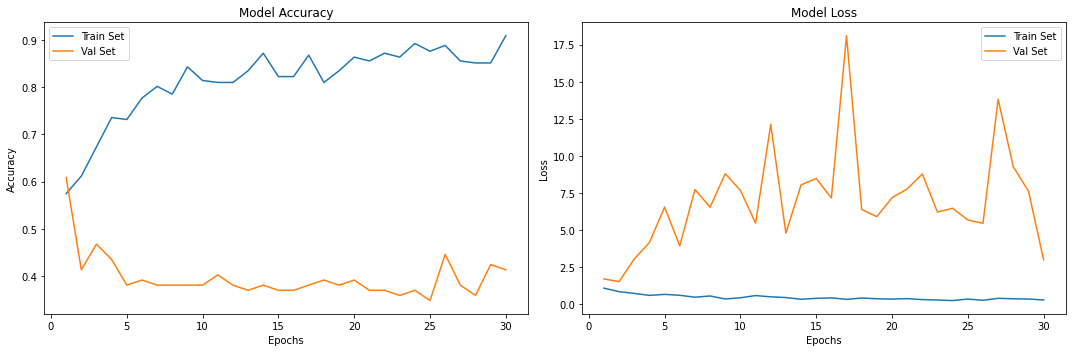

In [109]:
# plot model performance
acc = history_dense121.history['accuracy']
val_acc = history_dense121.history['val_accuracy']
loss = history_dense121.history['loss']
val_loss = history_dense121.history['val_loss']
epochs_range = range(1, len(history_dense.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [110]:
# validate on test set
predictions = model_dense121.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.91
Test Accuracy = 0.53
Val Accuracy = 0.41
Kappa Score = 0.01
ROC Area = 0.51
F1 Score = 0.42


### DenseNet 169

In [111]:
# load base model
base_model_dense = DenseNet169(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

51879936/51877672 [==============================] - 4s 0us/step


In [114]:
NUM_CLASSES = 1

model_dense169 = Sequential()
model_dense169.add(base_model_dense)
model_dense169.add(layers.Flatten())
model_dense169.add(layers.Dropout(0.5))
model_dense169.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_dense169.layers[0].trainable = False

model_dense169.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_dense169.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 7, 7, 1664)        12642880  
_________________________________________________________________
flatten_10 (Flatten)         (None, 81536)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 81536)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 81537     
Total params: 12,724,417
Trainable params: 81,537
Non-trainable params: 12,642,880
_________________________________________________________________


In [117]:
history_dense169 = model_dense169.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
8/8 [==============================] - 5s 676ms/step - loss: 0.1872 - accuracy: 0.9174 - val_loss: 6.7999 - val_accuracy: 0.3913
Epoch 2/30
8/8 [==============================] - 4s 516ms/step - loss: 0.1979 - accuracy: 0.9463 - val_loss: 5.1730 - val_accuracy: 0.3913
Epoch 3/30
8/8 [==============================] - 4s 548ms/step - loss: 0.2569 - accuracy: 0.9132 - val_loss: 8.5878 - val_accuracy: 0.3804
Epoch 4/30
8/8 [==============================] - 4s 535ms/step - loss: 0.1920 - accuracy: 0.9256 - val_loss: 12.6101 - val_accuracy: 0.3804
Epoch 5/30
8/8 [==============================] - 4s 536ms/step - loss: 0.2404 - accuracy: 0.9215 - val_loss: 14.9079 - val_accuracy: 0.3804
Epoch 6/30
8/8 [==============================] - 4s 549ms/step - loss: 0.1562 - accuracy: 0.9339 - val_loss: 19.5165 - val_accuracy: 0.3804
Epoch 7/30
8/8 [==============================] - 5s 566ms/step - loss: 0.1497 - accuracy: 0.9421 - val_loss: 3.8500 - val_accuracy: 0.4022
Epoch 8/30
8/8 [=

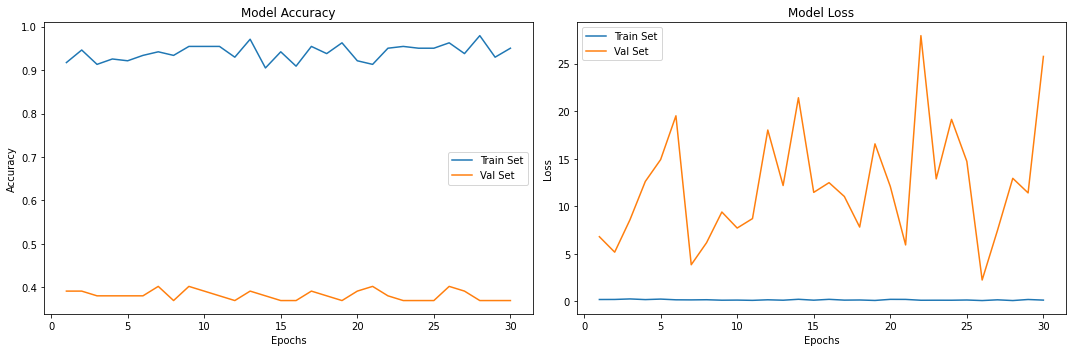

In [118]:
# plot model performance
acc = history_dense169.history['accuracy']
val_acc = history_dense169.history['val_accuracy']
loss = history_dense169.history['loss']
val_loss = history_dense169.history['val_loss']
epochs_range = range(1, len(history_dense.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [119]:
# validate on test set
predictions = model_dense169.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.95
Test Accuracy = 0.53
Val Accuracy = 0.37
Kappa Score = 0.00
ROC Area = 0.50
F1 Score = 0.34


C:\Users\zeyne\anaconda3\envs\keras-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### DenseNet 201

In [69]:
# load base model
base_model_dense = DenseNet201(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

74842112/74836368 [==============================] - 6s 0us/step


In [70]:
NUM_CLASSES = 1

model_dense = Sequential()
model_dense.add(base_model_dense)
model_dense.add(layers.Flatten())
model_dense.add(layers.Dropout(0.5))
model_dense.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_dense.layers[0].trainable = False

model_dense.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_dense.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten_2 (Flatten)          (None, 94080)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 94080)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 94081     
Total params: 18,416,065
Trainable params: 94,081
Non-trainable params: 18,321,984
_________________________________________________________________


In [71]:
history_dense = model_dense.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
8/8 [==============================] - 35s 4s/step - loss: 0.8837 - accuracy: 0.6488 - val_loss: 1.2820 - val_accuracy: 0.6630
Epoch 2/30
8/8 [==============================] - 4s 483ms/step - loss: 0.6191 - accuracy: 0.7355 - val_loss: 3.5815 - val_accuracy: 0.6196
Epoch 3/30
8/8 [==============================] - 4s 481ms/step - loss: 0.4233 - accuracy: 0.8264 - val_loss: 4.9148 - val_accuracy: 0.6196
Epoch 4/30
8/8 [==============================] - 4s 482ms/step - loss: 0.6303 - accuracy: 0.7231 - val_loss: 2.5974 - val_accuracy: 0.6413
Epoch 5/30
8/8 [==============================] - 4s 482ms/step - loss: 0.4678 - accuracy: 0.7769 - val_loss: 4.8208 - val_accuracy: 0.6196
Epoch 6/30
8/8 [==============================] - 4s 483ms/step - loss: 0.3709 - accuracy: 0.8140 - val_loss: 4.5795 - val_accuracy: 0.6196
Epoch 7/30
8/8 [==============================] - 4s 483ms/step - loss: 0.3889 - accuracy: 0.8306 - val_loss: 14.9563 - val_accuracy: 0.6196
Epoch 8/30
8/8 [=====

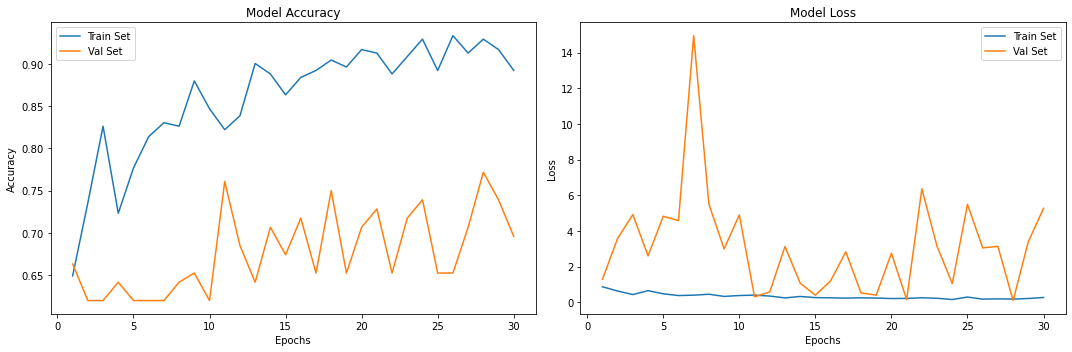

In [72]:
# plot model performance
acc = history_dense.history['accuracy']
val_acc = history_dense.history['val_accuracy']
loss = history_dense.history['loss']
val_loss = history_dense.history['val_loss']
epochs_range = range(1, len(history_dense.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [73]:
# validate on test set
predictions = model_dense.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.89
Test Accuracy = 0.58
Val Accuracy = 0.70
Kappa Score = 0.18
ROC Area = 0.59
Precision = 0.55


### InceptionV3

In [74]:
# load base model
base_model_inception = InceptionV3(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

87916544/87910968 [==============================] - 8s 0us/step


In [75]:
NUM_CLASSES = 1

model_inception= Sequential()
model_inception.add(base_model_inception)
model_inception.add(layers.Flatten())
model_inception.add(layers.Dropout(0.5))
model_inception.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_inception.layers[0].trainable = False

model_inception.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_inception.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51201     
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [76]:
history_inception = model_inception.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
8/8 [==============================] - 14s 2s/step - loss: 0.7973 - accuracy: 0.6033 - val_loss: 9.5488 - val_accuracy: 0.5652
Epoch 2/30
8/8 [==============================] - 1s 171ms/step - loss: 0.6581 - accuracy: 0.6612 - val_loss: 3.8814 - val_accuracy: 0.5870
Epoch 3/30
8/8 [==============================] - 3s 369ms/step - loss: 0.6533 - accuracy: 0.6901 - val_loss: 9.3681 - val_accuracy: 0.5870
Epoch 4/30
8/8 [==============================] - 3s 358ms/step - loss: 0.6018 - accuracy: 0.7231 - val_loss: 20.4024 - val_accuracy: 0.5978
Epoch 5/30
8/8 [==============================] - 3s 356ms/step - loss: 0.5796 - accuracy: 0.7190 - val_loss: 12.3151 - val_accuracy: 0.6087
Epoch 6/30
8/8 [==============================] - 3s 349ms/step - loss: 0.5209 - accuracy: 0.7686 - val_loss: 11.6438 - val_accuracy: 0.5870
Epoch 7/30
8/8 [==============================] - 3s 354ms/step - loss: 0.5685 - accuracy: 0.7314 - val_loss: 4.8965 - val_accuracy: 0.5761
Epoch 8/30
8/8 [===

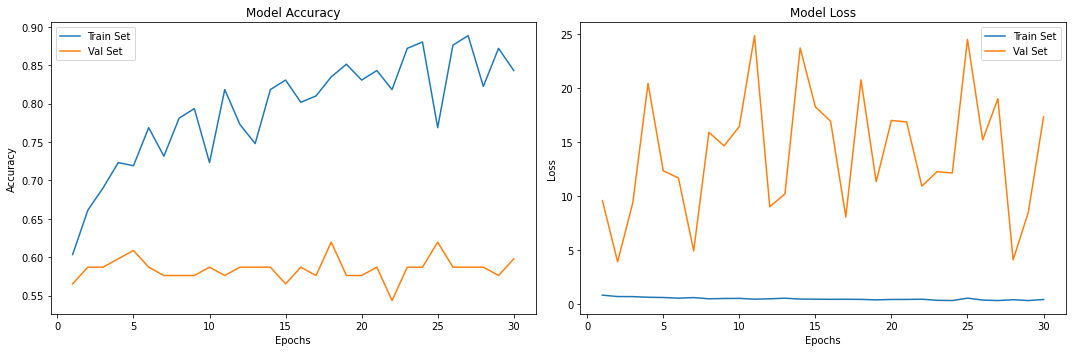

In [77]:
# plot model performance
acc = history_inception.history['accuracy']
val_acc = history_inception.history['val_accuracy']
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']
epochs_range = range(1, len(history_inception.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [79]:
# validate on test set
predictions = model_inception.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.84
Test Accuracy = 0.58
Val Accuracy = 0.60
Kappa Score = 0.19
ROC Area = 0.60
F1 Score = 0.51


### Xception

In [80]:
# load base model
base_model_xception = Xception(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

83689472/83683744 [==============================] - 7s 0us/step


In [81]:
NUM_CLASSES = 1

model_xception= Sequential()
model_xception.add(base_model_xception)
model_xception.add(layers.Flatten())
model_xception.add(layers.Dropout(0.5))
model_xception.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_xception.layers[0].trainable = False

model_xception.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_xception.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 100353    
Total params: 20,961,833
Trainable params: 100,353
Non-trainable params: 20,861,480
_________________________________________________________________


In [82]:
history_xception = model_xception.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
8/8 [==============================] - 12s 1s/step - loss: 0.6962 - accuracy: 0.6446 - val_loss: 8.1909 - val_accuracy: 0.6196
Epoch 2/30
8/8 [==============================] - 3s 407ms/step - loss: 0.5854 - accuracy: 0.6901 - val_loss: 4.0521 - val_accuracy: 0.6196
Epoch 3/30
8/8 [==============================] - 4s 538ms/step - loss: 0.4647 - accuracy: 0.8140 - val_loss: 5.8971 - val_accuracy: 0.6196
Epoch 4/30
8/8 [==============================] - 4s 512ms/step - loss: 0.5019 - accuracy: 0.7314 - val_loss: 6.2820 - val_accuracy: 0.6196
Epoch 5/30
8/8 [==============================] - 4s 498ms/step - loss: 0.4006 - accuracy: 0.8430 - val_loss: 6.3623 - val_accuracy: 0.6196
Epoch 6/30
8/8 [==============================] - 4s 489ms/step - loss: 0.3559 - accuracy: 0.8471 - val_loss: 4.7647 - val_accuracy: 0.6196
Epoch 7/30
8/8 [==============================] - 4s 554ms/step - loss: 0.3961 - accuracy: 0.8306 - val_loss: 9.7683 - val_accuracy: 0.6196
Epoch 8/30
8/8 [======

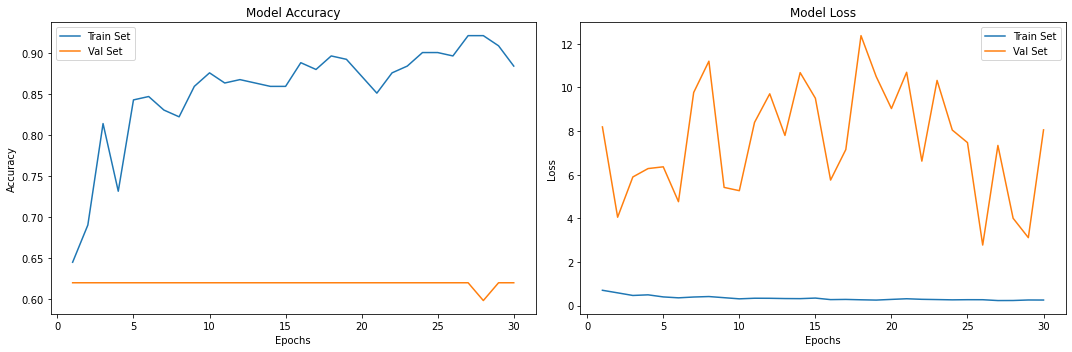

In [83]:
# plot model performance
acc = history_xception.history['accuracy']
val_acc = history_xception.history['val_accuracy']
loss = history_xception.history['loss']
val_loss = history_xception.history['val_loss']
epochs_range = range(1, len(history_xception.epoch) + 1)
IMG_PATH + CLASS
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
 
plt.tight_layout()
plt.show()

In [84]:
# validate on test set
predictions = model_xception.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.88
Test Accuracy = 0.47
Val Accuracy = 0.62
Kappa Score = 0.00
ROC Area = 0.50
F1 Score = 0.32


C:\Users\zeyne\anaconda3\envs\keras-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### MobileNet

In [ ]:
# load base model
base_model = MobileNet(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

In [144]:
NUM_CLASSES = 1

model_mobileNet= Sequential()
model_mobileNet.add(base_model)
model_mobileNet.add(layers.Flatten())
model_mobileNet.add(layers.Dropout(0.5))
model_mobileNet.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_mobileNet.layers[0].trainable = False

model_mobileNet.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_mobileNet.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_14 (Flatten)         (None, 38400)             0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 38400)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 38401     
Total params: 54,375,137
Trainable params: 38,401
Non-trainable params: 54,336,736
_________________________________________________________________


In [145]:
EPOCHS = 30
history_mobileNet = model_mobileNet.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
8/8 [==============================] - 20s 2s/step - loss: 0.6801 - accuracy: 0.6405 - val_loss: 103.8180 - val_accuracy: 0.6196
Epoch 2/30
8/8 [==============================] - 3s 378ms/step - loss: 0.6082 - accuracy: 0.6983 - val_loss: 120.9847 - val_accuracy: 0.6196
Epoch 3/30
8/8 [==============================] - 3s 413ms/step - loss: 0.5138 - accuracy: 0.7562 - val_loss: 24.9950 - val_accuracy: 0.6304
Epoch 4/30
8/8 [==============================] - 3s 434ms/step - loss: 0.5278 - accuracy: 0.7645 - val_loss: 47.2450 - val_accuracy: 0.6196
Epoch 5/30
8/8 [==============================] - 3s 416ms/step - loss: 0.5134 - accuracy: 0.7645 - val_loss: 101.6766 - val_accuracy: 0.6196
Epoch 6/30
8/8 [==============================] - 3s 424ms/step - loss: 0.4960 - accuracy: 0.7521 - val_loss: 107.3472 - val_accuracy: 0.6196
Epoch 7/30
8/8 [==============================] - 3s 406ms/step - loss: 0.5183 - accuracy: 0.7645 - val_loss: 56.6325 - val_accuracy: 0.6196
Epoch 8/30


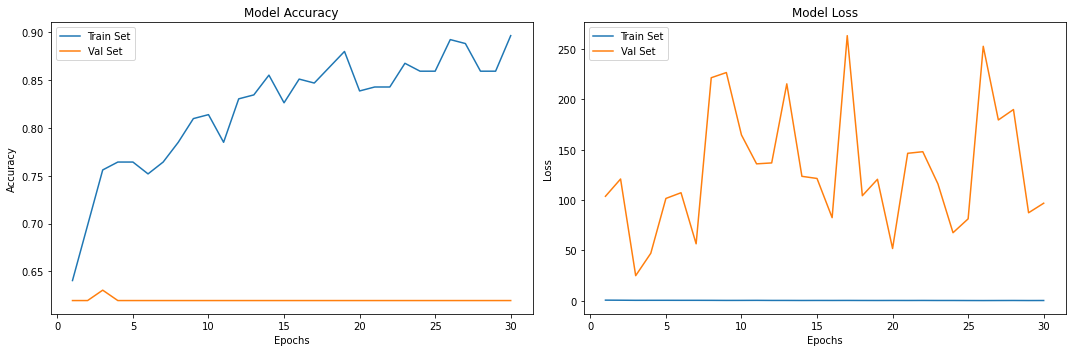

In [149]:
# plot model performance
acc = history_mobileNet.history['accuracy']
val_acc = history_mobileNet.history['val_accuracy']
loss = history_mobileNet.history['loss']
val_loss = history_mobileNet.history['val_loss']
epochs_range = range(1, len(history_mobileNet.epoch) + 1)
IMG_PATH + CLASS
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
 
plt.tight_layout()
plt.show()

In [150]:
# validate on test set
predictions = model_mobileNet.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.90
Test Accuracy = 0.47
Val Accuracy = 0.62
Kappa Score = 0.00
ROC Area = 0.50
F1 Score = 0.32


C:\Users\zeyne\anaconda3\envs\keras-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### MobileNetV2

In [85]:
# load base model
base_model_mobilenet = MobileNetV2(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

9412608/9406464 [==============================] - 1s 0us/step


In [86]:
NUM_CLASSES = 1

model_mobilenet= Sequential()
model_mobilenet.add(base_model_mobilenet)
model_mobilenet.add(layers.Flatten())
model_mobilenet.add(layers.Dropout(0.5))
model_mobilenet.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_mobilenet.layers[0].trainable = False

model_mobilenet.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_mobilenet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_5 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 62720)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 62721     
Total params: 2,320,705
Trainable params: 62,721
Non-trainable params: 2,257,984
_________________________________________________________________


In [87]:
EPOCHS = 30
history_mobilenet = model_mobilenet.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
8/8 [==============================] - 9s 1s/step - loss: 1.0065 - accuracy: 0.6157 - val_loss: 0.4984 - val_accuracy: 0.7065
Epoch 2/30
8/8 [==============================] - 1s 150ms/step - loss: 0.8720 - accuracy: 0.6736 - val_loss: 0.6633 - val_accuracy: 0.7500
Epoch 3/30
8/8 [==============================] - 3s 435ms/step - loss: 0.7446 - accuracy: 0.7149 - val_loss: 0.7085 - val_accuracy: 0.6196
Epoch 4/30
8/8 [==============================] - 4s 444ms/step - loss: 0.6651 - accuracy: 0.7190 - val_loss: 0.4476 - val_accuracy: 0.6739
Epoch 5/30
8/8 [==============================] - 5s 564ms/step - loss: 0.6885 - accuracy: 0.7231 - val_loss: 0.8958 - val_accuracy: 0.5761
Epoch 6/30
8/8 [==============================] - 4s 520ms/step - loss: 0.5822 - accuracy: 0.7521 - val_loss: 0.3978 - val_accuracy: 0.7717
Epoch 7/30
8/8 [==============================] - 6s 729ms/step - loss: 0.5013 - accuracy: 0.7727 - val_loss: 0.6284 - val_accuracy: 0.7500
Epoch 8/30
8/8 [=======

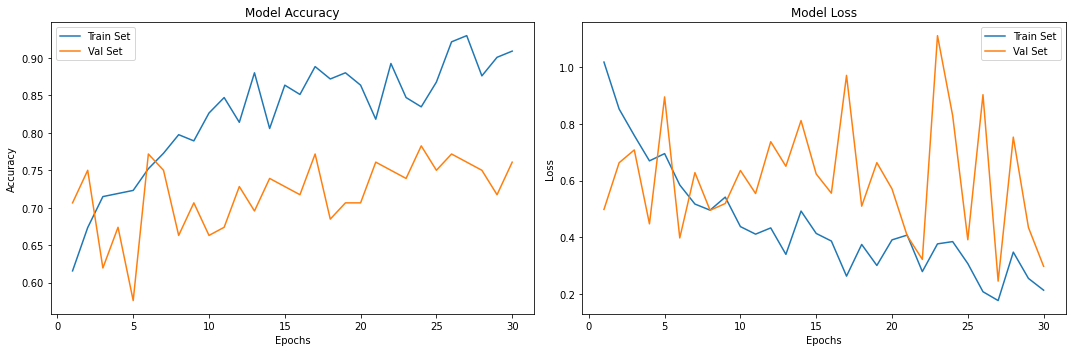

In [89]:
# plot model performance
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']
epochs_range = range(1, len(history_mobilenet.epoch) + 1)
IMG_PATH + CLASS
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
 
plt.tight_layout()
plt.show()

In [90]:
# validate on test set
predictions = model_mobilenet.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.91
Test Accuracy = 0.74
Val Accuracy = 0.76
Kappa Score = 0.49
ROC Area = 0.75
F1 Score = 0.72


### Resnet50

In [128]:
# load base model
base_model = ResNet50(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

C:\Users\zeyne\anaconda3\envs\keras-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning:

The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.



94658560/94653016 [==============================] - 11s 0us/step


In [129]:
NUM_CLASSES = 1

model_resnet50= Sequential()
model_resnet50.add(base_model)
model_resnet50.add(layers.Flatten())
model_resnet50.add(layers.Dropout(0.5))
model_resnet50.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_resnet50.layers[0].trainable = False

model_resnet50.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_resnet50.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_11 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 100352)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 100353    
Total params: 23,688,065
Trainable params: 100,353
Non-trainable params: 23,587,712
_________________________________________________________________


In [130]:
EPOCHS = 30
history_resnet50 = model_resnet50.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
8/8 [==============================] - 9s 1s/step - loss: 1.0437 - accuracy: 0.6488 - val_loss: 0.7609 - val_accuracy: 0.6739
Epoch 2/30
8/8 [==============================] - 2s 275ms/step - loss: 0.5782 - accuracy: 0.7851 - val_loss: 0.6090 - val_accuracy: 0.5978
Epoch 3/30
8/8 [==============================] - 3s 372ms/step - loss: 0.5092 - accuracy: 0.7851 - val_loss: 1.8291 - val_accuracy: 0.5870
Epoch 4/30
8/8 [==============================] - 3s 378ms/step - loss: 0.4491 - accuracy: 0.8182 - val_loss: 0.4776 - val_accuracy: 0.6957
Epoch 5/30
8/8 [==============================] - 3s 367ms/step - loss: 0.4709 - accuracy: 0.8430 - val_loss: 1.1215 - val_accuracy: 0.6196
Epoch 6/30
8/8 [==============================] - 3s 382ms/step - loss: 0.4779 - accuracy: 0.8264 - val_loss: 1.3202 - val_accuracy: 0.6957
Epoch 7/30
8/8 [==============================] - 3s 371ms/step - loss: 0.4639 - accuracy: 0.8140 - val_loss: 0.6643 - val_accuracy: 0.6739
Epoch 8/30
8/8 [=======

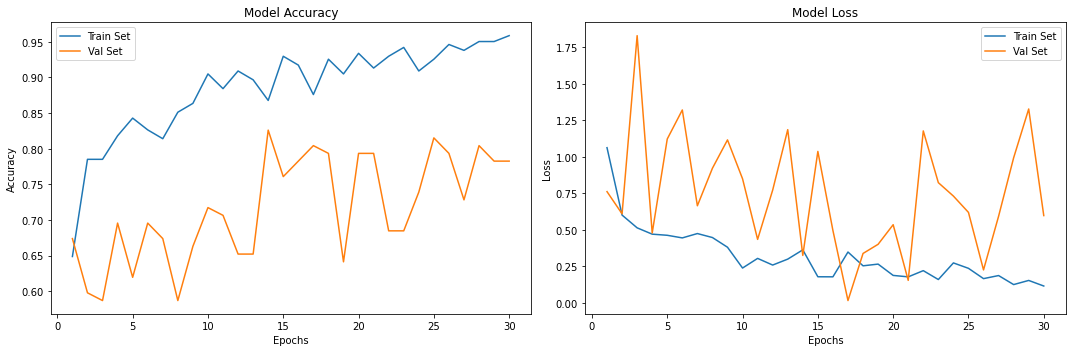

In [131]:
# plot model performance
acc = history_resnet50.history['accuracy']
val_acc = history_resnet50.history['val_accuracy']
loss = history_resnet50.history['loss']
val_loss = history_resnet50.history['val_loss']
epochs_range = range(1, len(history_mobilenet.epoch) + 1)
IMG_PATH + CLASS
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
 
plt.tight_layout()
plt.show()

In [132]:
# validate on test set
predictions = model_resnet50.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.96
Test Accuracy = 0.74
Val Accuracy = 0.78
Kappa Score = 0.46
ROC Area = 0.72
F1 Score = 0.71


### ResNet101

In [133]:
# load base model
base_model = ResNet101(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

171450368/171446536 [==============================] - 14s 0us/step


In [134]:
NUM_CLASSES = 1

model_resnet101= Sequential()
model_resnet101.add(base_model)
model_resnet101.add(layers.Flatten())
model_resnet101.add(layers.Dropout(0.5))
model_resnet101.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_resnet101.layers[0].trainable = False

model_resnet101.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_resnet101.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 7, 7, 2048)        42658176  
_________________________________________________________________
flatten_12 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 100352)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 100353    
Total params: 42,758,529
Trainable params: 100,353
Non-trainable params: 42,658,176
_________________________________________________________________


In [135]:
EPOCHS = 30
history_resnet101 = model_resnet101.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
8/8 [==============================] - 11s 1s/step - loss: 0.9199 - accuracy: 0.6901 - val_loss: 0.5940 - val_accuracy: 0.6739
Epoch 2/30
8/8 [==============================] - 4s 443ms/step - loss: 0.5825 - accuracy: 0.7810 - val_loss: 0.4586 - val_accuracy: 0.8152
Epoch 3/30
8/8 [==============================] - 4s 444ms/step - loss: 0.6437 - accuracy: 0.7851 - val_loss: 0.5579 - val_accuracy: 0.7935
Epoch 4/30
8/8 [==============================] - 4s 445ms/step - loss: 0.3558 - accuracy: 0.8388 - val_loss: 0.2478 - val_accuracy: 0.8696
Epoch 5/30
8/8 [==============================] - 4s 445ms/step - loss: 0.4858 - accuracy: 0.8306 - val_loss: 0.1762 - val_accuracy: 0.7717
Epoch 6/30
8/8 [==============================] - 4s 445ms/step - loss: 0.5665 - accuracy: 0.8058 - val_loss: 1.3485 - val_accuracy: 0.7717
Epoch 7/30
8/8 [==============================] - 4s 446ms/step - loss: 0.4504 - accuracy: 0.8471 - val_loss: 0.0703 - val_accuracy: 0.8152
Epoch 8/30
8/8 [======

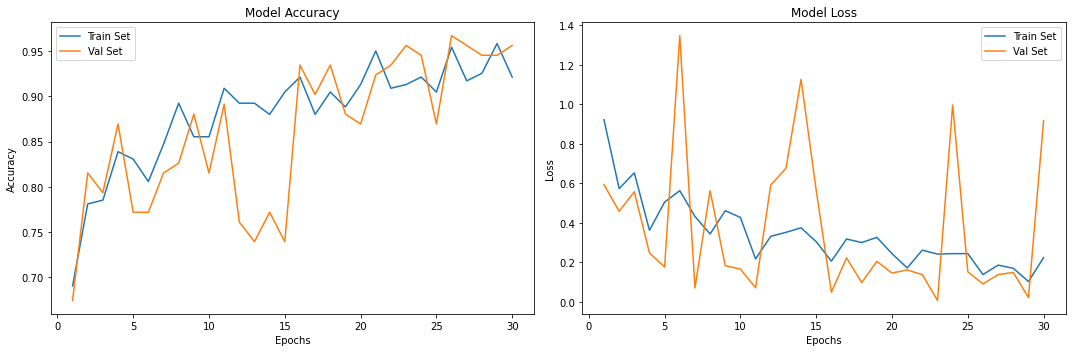

In [136]:
# plot model performance
acc = history_resnet101.history['accuracy']
val_acc = history_resnet101.history['val_accuracy']
loss = history_resnet101.history['loss']
val_loss = history_resnet101.history['val_loss']
epochs_range = range(1, len(history_mobilenet.epoch) + 1)
IMG_PATH + CLASS
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
 
plt.tight_layout()
plt.show()

In [137]:
# validate on test set
predictions = model_resnet101.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.92
Test Accuracy = 0.89
Val Accuracy = 0.96
Kappa Score = 0.79
ROC Area = 0.89
F1 Score = 0.89


### InceptionResNetV2

In [138]:
# load base model
base_model = InceptionResNetV2(
    weights = 'imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,))

219062272/219055592 [==============================] - 23s 0us/step


In [139]:
NUM_CLASSES = 1

model_inceptionRNV2= Sequential()
model_inceptionRNV2.add(base_model)
model_inceptionRNV2.add(layers.Flatten())
model_inceptionRNV2.add(layers.Dropout(0.5))
model_inceptionRNV2.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_inceptionRNV2.layers[0].trainable = False

model_inceptionRNV2.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_inceptionRNV2.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_13 (Flatten)         (None, 38400)             0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 38400)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 38401     
Total params: 54,375,137
Trainable params: 38,401
Non-trainable params: 54,336,736
_________________________________________________________________


In [140]:
EPOCHS = 30
history_inceptionRNV2 = model_inceptionRNV2.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
8/8 [==============================] - 23s 3s/step - loss: 0.7400 - accuracy: 0.5826 - val_loss: 33.4862 - val_accuracy: 0.6196
Epoch 2/30
8/8 [==============================] - 3s 377ms/step - loss: 0.6427 - accuracy: 0.6322 - val_loss: 93.3936 - val_accuracy: 0.6196
Epoch 3/30
8/8 [==============================] - 3s 392ms/step - loss: 0.5549 - accuracy: 0.7066 - val_loss: 130.9709 - val_accuracy: 0.6196
Epoch 4/30
8/8 [==============================] - 3s 396ms/step - loss: 0.6082 - accuracy: 0.7066 - val_loss: 118.9877 - val_accuracy: 0.6196
Epoch 5/30
8/8 [==============================] - 3s 395ms/step - loss: 0.5168 - accuracy: 0.7479 - val_loss: 153.9962 - val_accuracy: 0.6196
Epoch 6/30
8/8 [==============================] - 3s 386ms/step - loss: 0.4729 - accuracy: 0.7686 - val_loss: 59.8883 - val_accuracy: 0.6196
Epoch 7/30
8/8 [==============================] - 3s 390ms/step - loss: 0.5123 - accuracy: 0.7603 - val_loss: 208.9035 - val_accuracy: 0.6196
Epoch 8/30


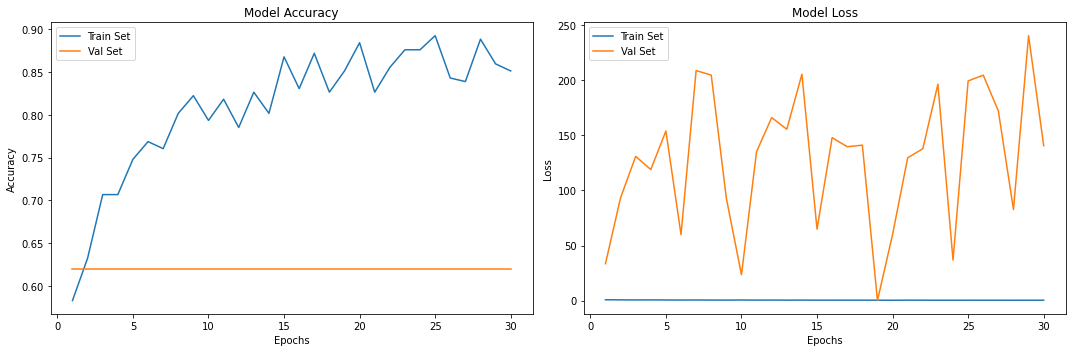

In [142]:
# plot model performance
acc = history_inceptionRNV2.history['accuracy']
val_acc = history_inceptionRNV2.history['val_accuracy']
loss = history_inceptionRNV2.history['loss']
val_loss = history_inceptionRNV2.history['val_loss']
epochs_range = range(1, len(history_mobilenet.epoch) + 1)
IMG_PATH + CLASS
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
 
plt.tight_layout()
plt.show()

In [143]:
# validate on test set
predictions = model_inceptionRNV2.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.85
Test Accuracy = 0.47
Val Accuracy = 0.62
Kappa Score = 0.00
ROC Area = 0.50
F1 Score = 0.32


C:\Users\zeyne\anaconda3\envs\keras-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## CNN custom NNs

In [14]:
input_shape = (224, 224, 3) 
NUM_CLASSES = 1
def model_cnn2():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=1))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
        
    return model

model_cnn2 = model_cnn2()

model_cnn2.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model_cnn2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation_9 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_10 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 32)     

In [15]:
EPOCHS = 30
history_cnn2 = model_cnn2.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/30
16/16 [==============================] - 4s 249ms/step - loss: 6.4012 - accuracy: 0.5331 - val_loss: 23.1962 - val_accuracy: 0.3696
Epoch 2/30
16/16 [==============================] - 2s 147ms/step - loss: 2.5002 - accuracy: 0.6488 - val_loss: 2.3971 - val_accuracy: 0.4457
Epoch 3/30
16/16 [==============================] - 3s 171ms/step - loss: 1.9582 - accuracy: 0.6612 - val_loss: 8.5522 - val_accuracy: 0.4130
Epoch 4/30
16/16 [==============================] - 3s 174ms/step - loss: 2.2281 - accuracy: 0.6653 - val_loss: 4.5628 - val_accuracy: 0.4348
Epoch 5/30
16/16 [==============================] - 3s 179ms/step - loss: 2.6054 - accuracy: 0.5744 - val_loss: 0.8951 - val_accuracy: 0.6957
Epoch 6/30
16/16 [==============================] - 3s 171ms/step - loss: 1.9692 - accuracy: 0.6694 - val_loss: 0.6935 - val_accuracy: 0.7283
Epoch 7/30
16/16 [==============================] - 3s 182ms/step - loss: 1.8594 - accuracy: 0.6322 - val_loss: 0.6780 - val_accuracy: 0.7500
Epoch

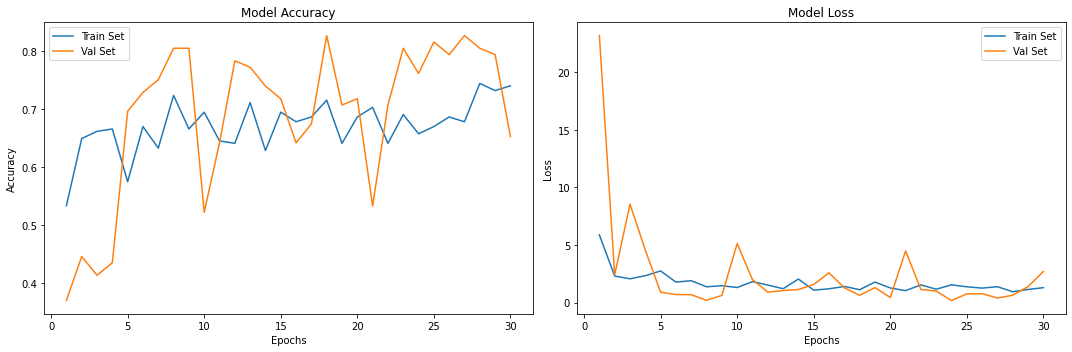

In [17]:
# plot model performance
acc = history_cnn2.history['accuracy']
val_acc = history_cnn2.history['val_accuracy']
loss = history_cnn2.history['loss']
val_loss = history_cnn2.history['val_loss']
epochs_range = range(1, len(history_cnn2.epoch) + 1)
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
 
plt.tight_layout()
plt.show()

In [18]:
# validate on test set
predictions = model_cnn2.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

kappa_score = cohen_kappa_score(y_test, predictions)

roc_area = roc_auc_score(y_test, predictions)

(precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')

print('Train Accuracy = %.2f' % acc[-1])
print('Test Accuracy = %.2f' % accuracy)
print('Val Accuracy = %.2f' % val_acc[-1])
print('Kappa Score = %.2f' % kappa_score)
print('ROC Area = %.2f' % roc_area)
print('F1 Score = %.2f' % fscore)

Train Accuracy = 0.74
Test Accuracy = 0.58
Val Accuracy = 0.65
Kappa Score = 0.13
ROC Area = 0.56
F1 Score = 0.51
